In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('final_cleaned_dataset.csv')

In [3]:
print(df.shape)
df.head()


(29381, 35)


,id,loan_amount,funded_amount,term,int_rate,grade,sub_grade,employment_length,home_ownership,annual_inc,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,17.470218,13200,13200,36 months,6.99,A,A3,9 years,RENT,7.898282,...,6.669422,0.0,0.0,0.0,2022-01-01,5.293713,2022-01-01,0.0,1,INDIVIDUAL
1,17.470214,26500,26500,36 months,19.99,E,E3,< 1 year,RENT,8.123566,...,8.001328,0.0,0.0,0.0,2021-08-01,5.707195,2022-01-01,0.0,1,INDIVIDUAL
2,17.470214,10000,10000,60 months,12.99,C,C2,< 1 year,RENT,7.898775,...,7.092948,0.0,0.0,0.0,2022-01-01,4.840113,2022-01-01,0.0,1,INDIVIDUAL
3,17.470214,10000,0,36 months,8.19,A,A5,10+ years,MORTGAGE,8.261314,...,6.552622,0.0,0.0,0.0,2022-01-01,5.092810,2022-01-01,0.0,1,INDIVIDUAL
4,17.470213,7200,7200,36 months,8.19,A,A5,7 years,OWN,8.177951,...,6.224103,0.0,0.0,0.0,2022-01-01,4.835880,2022-01-01,0.0,1,INDIVIDUAL


In [4]:
# Summarise what percentage of the loans have been currently recovered compared to the total amount to be paid over the loans term including interest.

# Convert 'term' to numeric (36 or 60)
df['term_numeric'] = df['term'].map({'36 months': 36, '60 months': 60})

# Calculate loan payment over term including interest
df['loan_payment_with_interest'] = df['funded_amount'] + (df['funded_amount'] * (df['int_rate'] / 100) * (df['term_numeric'] / 12))

# Sum the total payments received to date
total_payment_sum_all = df['total_payment'].sum()

# Sum the total loan payment
loan_payment_with_interest_sum_all = df['loan_payment_with_interest'].sum()

# Calculate the overall percentage recovered for all loans 
overall_percentage_recovered_all = (total_payment_sum_all / loan_payment_with_interest_sum_all) * 100

# Output the overall recovery percentage
print(f"Overall Percentage of Loans Recovered: {overall_percentage_recovered_all:.2f}%")



Overall Percentage of Loans Recovered: 67.11%


In [5]:
# Additionally calculate how much will be paid back in 6 months time with interest. 

# Since instalment was dropped due to a high correlation with another column, I will need to recalculate it using other variables. This can be done with the amortization formula

# Convert annual interest rate to monthly interest rate
df['monthly_interest_rate'] = (df['int_rate'] / 100) / 12

# Calculate the monthly instalment using the amortization formula
df['instalment'] = df['loan_amount'] * (df['monthly_interest_rate'] * (1 + df['monthly_interest_rate'])**df['term_numeric']) / \
                   ((1 + df['monthly_interest_rate'])**df['term_numeric'] - 1)

print(df[['loan_amount', 'int_rate', 'term', 'term_numeric', 'instalment']].head())


   loan_amount  int_rate       term  term_numeric  instalment
0        13200      6.99  36 months            36  407.517329
1        26500     19.99  36 months            36  984.699940
2        10000     12.99  60 months            60  227.479543
3        10000      8.19  36 months            36  314.240902
4         7200      8.19  36 months            36  226.253449


In [6]:
# Projected payments in the next 6 months
df['projected_payment_6_months'] = df['instalment'] * 6
projected_payment_6_months_sum = df['projected_payment_6_months'].sum()


# Calculate the total projected payment
projected_total_payment = total_payment_sum_all + projected_payment_6_months_sum

# Calculate the projected recovery percentage in 6 months
projected_recovery_percentage = (projected_total_payment / loan_payment_with_interest_sum_all) * 100

print(f"Projected Overall Recovery Percentage in 6 Months: {projected_recovery_percentage:.2f}%")

Projected Overall Recovery Percentage in 6 Months: 80.27%


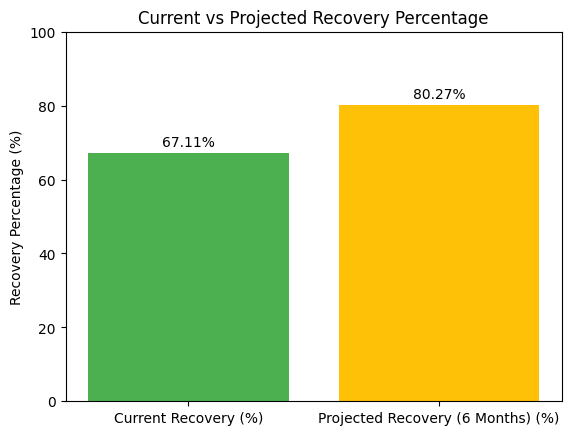

In [7]:
# Visualise

plt.bar(
    ['Current Recovery (%)', 'Projected Recovery (6 Months) (%)'], 
    [overall_percentage_recovered_all, projected_recovery_percentage], 
    color=['#4CAF50', '#FFC107']
)

plt.title('Current vs Projected Recovery Percentage')
plt.ylabel('Recovery Percentage (%)')
plt.ylim(0, 100)

# Add values on top of the bars
for i, value in enumerate([overall_percentage_recovered_all, projected_recovery_percentage]):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

In [8]:
# Calculate the percentage of charged off loans and the total amount that was paid towards these loans before being charged off.

# Filter out the Charged Off loans
charged_off_loans = df[df['loan_status'] == 'Charged Off']

# Percentage of Charged Off loans
total_loans = len(df) 
charged_off_loans_count = len(charged_off_loans) 
charged_off_percentage = (charged_off_loans_count / total_loans) * 100

# Total amount paid towards Charged Off loans
total_paid_charged_off = charged_off_loans['total_payment'].sum()

print(f"Percentage of Charged Off Loans: {charged_off_percentage:.2f}%")
print(f"Total Amount Paid on Charged Off Loans: £{total_paid_charged_off:,.2f}")



Percentage of Charged Off Loans: 3.67%
Total Amount Paid on Charged Off Loans: £5,936,405.51


In [9]:
# Calculate the expected loss of the loans marked as Charged Off.

# Filter out the Charged Off loans
charged_off_loans = df[df['loan_status'] == 'Charged Off']

# Calculate the expected loss (interest lost due to charge-off)
charged_off_loans['expected_loss'] = (
    (charged_off_loans['funded_amount'] * (charged_off_loans['int_rate'] / 100) * (charged_off_loans['term_numeric'] / 12)) - charged_off_loans['funded_amount']  
) - (charged_off_loans['total_payment'] - charged_off_loans['funded_amount'])  

# Total Expected Loss across all charged-off loans
total_expected_loss = charged_off_loans['expected_loss'].sum()

print(f"Total Expected Loss (Interest Lost): £{total_expected_loss:,.2f}")


Total Expected Loss (Interest Lost): £1,760,454.40


/var/folders/09/p5rjt7sx02vc259gbvxmxsjm0000gn/T/ipykernel_59424/725223108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_loans['expected_loss'] = (


In [10]:
# Calculate the loss in revenue these loans would have generated for the company if they had finished their term. 

# The total expected revenue (principal + interest) if the loan had finished its term
charged_off_loans['total_expected_revenue'] = (
    charged_off_loans['funded_amount'] + 
    (charged_off_loans['funded_amount'] * charged_off_loans['int_rate'] / 100 * charged_off_loans['term_numeric'] / 12)
)

# Difference between total expected revenue and payments received so far)
charged_off_loans['loss_in_revenue'] = charged_off_loans['total_expected_revenue'] - charged_off_loans['total_payment']


# Total Loss in Revenue across all charged-off loans
total_loss_in_revenue = charged_off_loans['loss_in_revenue'].sum()

print(f"Total Loss in Revenue: £{total_loss_in_revenue:,.2f}")


Total Loss in Revenue: £15,239,929.39


/var/folders/09/p5rjt7sx02vc259gbvxmxsjm0000gn/T/ipykernel_59424/1721365728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_loans['total_expected_revenue'] = (
/var/folders/09/p5rjt7sx02vc259gbvxmxsjm0000gn/T/ipykernel_59424/1721365728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_loans['loss_in_revenue'] = charged_off_loans['total_expected_revenue'] - charged_off_loans['total_payment']


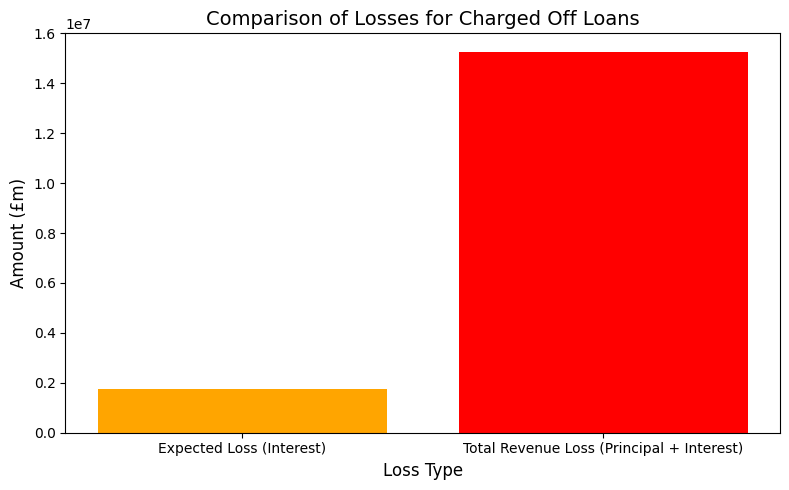

In [11]:
# Visualise the loss projected over the remaining term of these loans.

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['Expected Loss (Interest)', 'Total Revenue Loss (Principal + Interest)']
values = [total_expected_loss, total_loss_in_revenue]

ax.bar(labels, values, color=['orange', 'red'])

# Add titles and labels
ax.set_title('Comparison of Losses for Charged Off Loans', fontsize=14)
ax.set_ylabel('Amount (£m)', fontsize=12)
ax.set_xlabel('Loss Type', fontsize=12)
plt.tight_layout()

plt.show()


In [12]:
# There are customers who are currently behind with their loan payments. This subset of customers represent a risk to company revenue.
# What percentage do users in this bracket currently represent?

print(df.value_counts('loan_status'))

# Loan statuses for customers behind on payments
late_statuses = ['Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period', 'Default']

# Filter rows with late statuses
late_customers = df[df['loan_status'].isin(late_statuses)]

# Percentage
percentage_late_customers = (len(late_customers) / len(df)) * 100
print(f"Percentage of Customers Behind on Payments: {percentage_late_customers:.2f}%")



loan_status
Fully Paid                                             16285
Current                                                10970
Charged Off                                             1078
Does not meet the credit policy. Status:Fully Paid       526
Late (31-120 days)                                       260
In Grace Period                                          135
Does not meet the credit policy. Status:Charged Off       60
Late (16-30 days)                                         42
Default                                                   25
Name: count, dtype: int64
Percentage of Customers Behind on Payments: 1.57%


In [13]:
# Calculate the total amount of customers in this bracket and how much loss the company would incur if their status was changed to Charged Off.

# Total number of customers in this bracket
total_late_customers = len(late_customers)
print(f"Total Number of Customers Behind on Payments: {total_late_customers}")

# Estimate how many months remain in the loan term based on the payments already made.
late_customers['remaining_months'] = late_customers['term_numeric'] - late_customers['term_numeric'] * (
    late_customers['total_payment'] / 
    (late_customers['funded_amount'] + (late_customers['funded_amount'] * late_customers['int_rate'] / 100))
)

# Projected loss = Remaining Principal + Remaining Interest
late_customers['projected_loss'] = (
    late_customers['funded_amount'] * (1 - late_customers['total_payment'] / late_customers['funded_amount']) +
    late_customers['funded_amount'] * late_customers['int_rate'] / 100 * late_customers['remaining_months'] / 12
)

# Total projected loss
total_projected_loss = late_customers['projected_loss'].sum()

print(f"Total Projected Loss if Changed to Charged Off: £{total_projected_loss:,.2f}")


Total Number of Customers Behind on Payments: 462
Total Projected Loss if Changed to Charged Off: £3,459,423.61


/var/folders/09/p5rjt7sx02vc259gbvxmxsjm0000gn/T/ipykernel_59424/169590612.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_customers['remaining_months'] = late_customers['term_numeric'] - late_customers['term_numeric'] * (
/var/folders/09/p5rjt7sx02vc259gbvxmxsjm0000gn/T/ipykernel_59424/169590612.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_customers['projected_loss'] = (


In [14]:

# What is the projected loss of these loans if the customer were to finish the full loan term?

# Total expected revenue (principal + interest)
late_customers['total_expected_revenue'] = (
    late_customers['funded_amount'] + 
    (late_customers['funded_amount'] * late_customers['int_rate'] / 100 * late_customers['term_numeric'] / 12)
)

# Projected loss for each customer
late_customers['projected_loss_if_full_term'] = (
    late_customers['total_expected_revenue'] - late_customers['total_payment']
)

# Total projected loss for all late customers
total_projected_loss_if_full_term = late_customers['projected_loss_if_full_term'].sum()
print(f"Total Projected Loss if Customers Finish Full Term: £{total_projected_loss_if_full_term:,.2f}")


Total Projected Loss if Customers Finish Full Term: £5,406,529.92


/var/folders/09/p5rjt7sx02vc259gbvxmxsjm0000gn/T/ipykernel_59424/306900928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_customers['total_expected_revenue'] = (
/var/folders/09/p5rjt7sx02vc259gbvxmxsjm0000gn/T/ipykernel_59424/306900928.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_customers['projected_loss_if_full_term'] = (


In [15]:
# If customers that are late on payments converted to Charged Off, what percentage of total expected revenue do these customers and the customers who have already defaulted on their loan represent?

# Late and charged off customers
late_charged_off_status = ['Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period', 'Default', 'Charged Off']

# Total expected revenue for all customers
df['total_expected_revenue'] = (
    df['funded_amount'] + 
    (df['funded_amount'] * df['int_rate'] / 100 * df['term_numeric'] / 12)
)
total_expected_revenue_all = df['total_expected_revenue'].sum()
print(f"Total Expected Revenue of All Customers: £{total_expected_revenue_all:,.2f}")

# Filter rows for late and charged-off customers
late_charged_off = df[df['loan_status'].isin(late_charged_off_status)]

# Total expected revenue for late and charged-off customers
total_expected_revenue_late_charged_off = late_charged_off['total_expected_revenue'].sum()
print(f"Total Expected Revenue of Late and Charged-Off Customers: £{total_expected_revenue_late_charged_off:,.2f}")

# Percentage of expected revenue at risk
percentage_revenue_at_risk = (total_expected_revenue_late_charged_off / total_expected_revenue_all) * 100
print(f"Percentage of Expected Revenue at Risk: {percentage_revenue_at_risk:.2f}%")


Total Expected Revenue of All Customers: £500,104,447.35
Total Expected Revenue of Late and Charged-Off Customers: £31,047,026.29
Percentage of Expected Revenue at Risk: 6.21%


In [16]:
# To help identify which columns will be of interest, first create a subset of these users

# Customers who have stopped paying
charged_off_customers = df[df['loan_status'].isin(['Charged Off', 'Default', 'Does not meet the credit policy. Status: Charged Off'])]

# Late customers
late_customers = df[df['loan_status'].isin(['Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'])]

# Customers who are fully paid or current
paid_customers = df[df['loan_status'].isin(['Fully Paid', 'Current', 'Does not meet the credit policy. Status: Fully Paid'])]


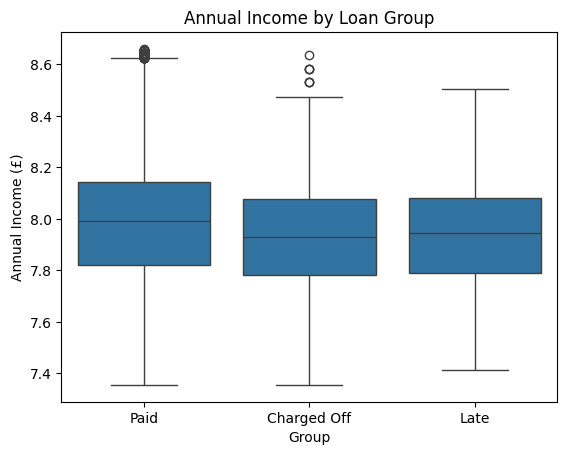

In [17]:

# Combine data for group comparison
df.loc[charged_off_customers.index, 'group'] = 'Charged Off'
df.loc[late_customers.index, 'group'] = 'Late'
df.loc[paid_customers.index, 'group'] = 'Paid'

# Boxplot for annual income
sns.boxplot(data=df, x='group', y='annual_inc')
plt.title('Annual Income by Loan Group')
plt.xlabel('Group')
plt.ylabel('Annual Income (£)')
plt.show()


In [ ]:
# Box plot clearly shows customers with a higher annual income are less likely to be late or default on their loan

loan_status
Fully Paid                                             16285
Current                                                10970
Charged Off                                             1078
Does not meet the credit policy. Status:Fully Paid       526
Late (31-120 days)                                       260
In Grace Period                                          135
Does not meet the credit policy. Status:Charged Off       60
Late (16-30 days)                                         42
Default                                                   25
Name: count, dtype: int64

In [ ]:
# Firstly, looking at DTI (debt-to-income). The box plot shows customers that have a higher DTI ratio are more likely to be late or charged off. 
# Customers with a larger loan (funded amount) are also more likely to be late or charged off.
# Customers with the highest interest rate on their loan are more likely to be late or charged off. 

#In all 3 cases the charged off was closer to the paid group than the late group which is a slight surprise. 

In [22]:
# Chi-squared test for categorical variables

def perform_chi_square_test(column):
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], df['group'])
    
    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Test for {column}")
    print(f"Chi-Square Statistic: {chi2:.2f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-Value: {p:.5f}")
    print("-" * 50)

    # Interpretation
    if p < 0.05:
        print(f"Result: The distribution of {column} is significantly associated with the groups (p < 0.05).")
    else:
        print(f"Result: No significant association for {column} (p >= 0.05).")
    print()

# Perform the test for the categorical variables
categorical_columns = ['term', 'grade', 'home_ownership', 'purpose']
for column in categorical_columns:
    perform_chi_square_test(column)

Chi-Square Test for term
Chi-Square Statistic: 84.82
Degrees of Freedom: 2
P-Value: 0.00000
--------------------------------------------------
Result: The distribution of term is significantly associated with the groups (p < 0.05).

Chi-Square Test for grade
Chi-Square Statistic: 360.64
Degrees of Freedom: 12
P-Value: 0.00000
--------------------------------------------------
Result: The distribution of grade is significantly associated with the groups (p < 0.05).

Chi-Square Test for home_ownership
Chi-Square Statistic: 12.24
Degrees of Freedom: 6
P-Value: 0.05686
--------------------------------------------------
Result: No significant association for home_ownership (p >= 0.05).

Chi-Square Test for purpose
Chi-Square Statistic: 83.69
Degrees of Freedom: 26
P-Value: 0.00000
--------------------------------------------------
Result: The distribution of purpose is significantly associated with the groups (p < 0.05).



In [ ]:
# Term - The term of the loan is significantly associated with whether a customer falls into the paid, late, or charged-off groups. This means the term could be an indicator of repayment likelihood.
# Grade - The grade of the loan has a strong and significant association with the repayment group. Loan grade is likely a key indicator of whether a customer is at risk of not paying.
# Home Ownership - p is greater than 0.05 suggesting no significant association for home ownership, therefore it is not a reliable indicator of repayment behavior in this dataset.
# Purpose - The purpose of the loan has a significant association with repayment groups, making it a potential indicator of loan performance.

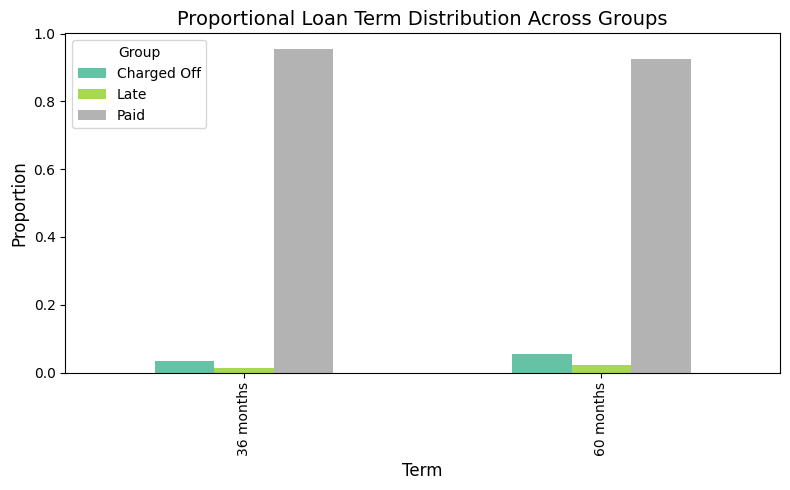

In [24]:
# Visualising term with a bar plot are normalising the counts

term_group = df.groupby(['term', 'group']).size().unstack(fill_value=0)
term_group = term_group.div(term_group.sum(axis=1), axis=0)

term_group.plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title('Proportional Loan Term Distribution Across Groups', fontsize=14)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

In [ ]:
# Loans with a term of 60 months seem to lead to a higher likelihood of being late or charged off

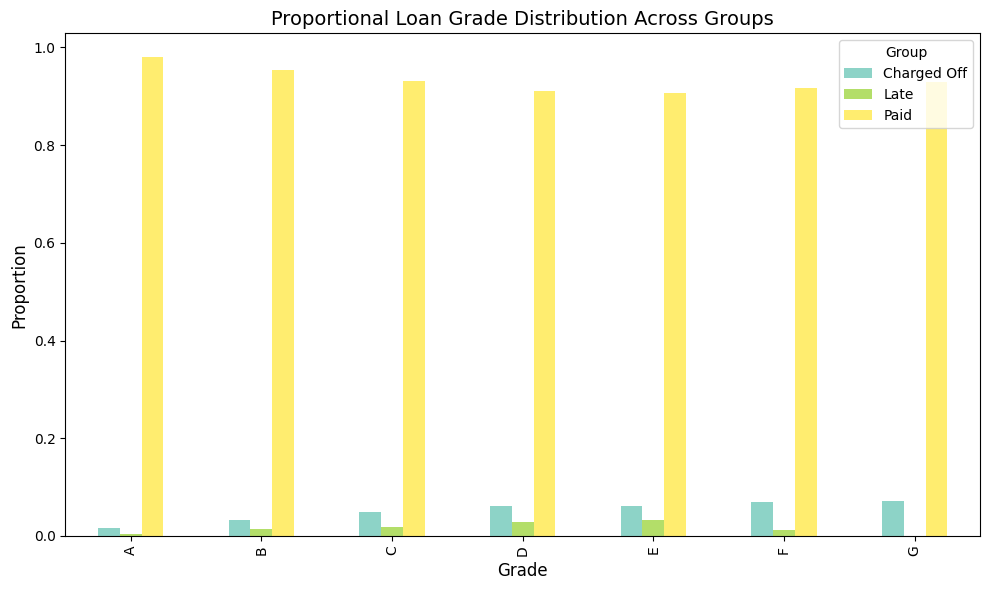

In [ ]:
# Visualising grade 

grade_group = df.groupby(['grade', 'group']).size().unstack(fill_value=0)
grade_group = grade_group.div(grade_group.sum(axis=1), axis=0)

grade_group.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title('Proportional Loan Grade Distribution Across Groups', fontsize=14)
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

In [ ]:
#  Lower grades (e.g., F and G) are associated with a higher risk of charged-off loans, while higher grades (e.g., A and B) are predominantly paid or current. There seems to be a There is a progression of risk: higher grades tend to be paid, middle grades tend to have more late loans, and lower grades are more likely to be charged off.

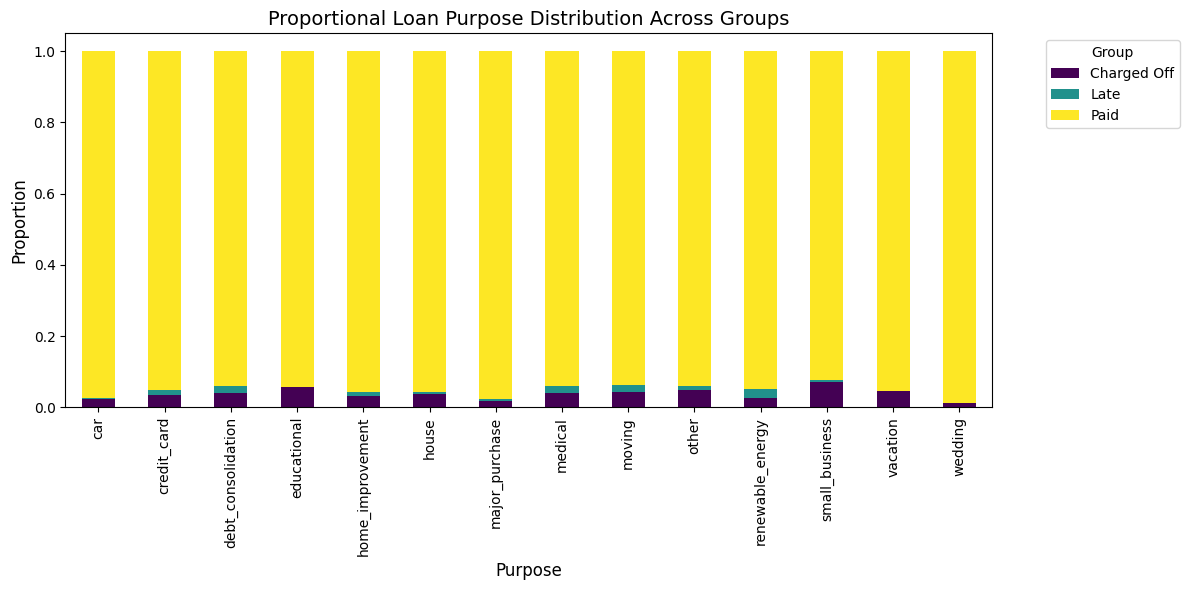

In [26]:
# Visualising Purpose 
purpose_group = df.groupby(['purpose', 'group']).size().unstack(fill_value=0)
purpose_group = purpose_group.div(purpose_group.sum(axis=1), axis=0)  # Normalize by purpose

purpose_group.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Proportional Loan Purpose Distribution Across Groups', fontsize=14)
plt.xlabel('Purpose', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Small_business loans have a noticeable proportion of customers who end up charged off. This could suggest a high risk associated with this purpose.
# Medical and educational loans may indicate potential financial struggles, as seen in the late group, but do not yet show a significant risk of being charged off.
# Loan purposes like wedding and vacation are lower risk, with most customers paying these loans off. 